# Centralized Log Management System for Threat Monitoring (UNSW-NB15)

**Author:** .....................  
**Date:** 2025-08-13

---

This notebook implements a memory-efficient, production-minded **Centralized Log Management System (CLMS)** for threat monitoring using the **UNSW-NB15** dataset. It covers:

- Automated dataset fetch + robust failure handling
- Chunked ingestion with dtype optimization (<= 8GB RAM friendly)
- Preprocessing & feature engineering (categoricals + numeric scaling)
- EDA with professional plots (class distribution, correlations, feature importance)
- Modeling: **Baseline** (Incremental Logistic Regression via `SGDClassifier`) and **Optimized** (Scikit-learn `HistGradientBoostingClassifier`; optional XGBoost if installed)
- Full evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC & AUC
- **Centralized log pipeline simulation** for near-real-time scoring and alerting
- Clear, modular code for integration into production

> **Dataset**: [UNSW-NB15](https://research.unsw.edu.au/projects/unsw-nb15-dataset)


## 1. Introduction

Modern security operations require collecting logs from multiple sources (network, system, application), centralizing them, and applying analytics to detect threats in real-time or near-real-time.
This notebook provides an end-to-end, memory-conscious blueprint you can adapt to your environment.


## 2. Setup & Configuration

- Paths and memory limits
- Download mirrors for UNSW-NB15 (graceful handling when offline)
- Lightweight dependencies by default (sklearn/matplotlib/seaborn); optional XGBoost if installed


In [40]:
# === Configuration ===
from pathlib import Path
import os, sys, shutil, hashlib, warnings, io, zipfile, tarfile, gzip, bz2, lzma, tempfile, json
from typing import Iterator, Tuple, Dict, Any, List, Optional

DATA_DIR = Path("./data_unsw_nb15")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Known filenames for all UNSW-NB15 CSV files
TRAIN_CSV = DATA_DIR / "UNSW_NB15_training-set.csv"
TEST_CSV = DATA_DIR / "UNSW_NB15_testing-set.csv"
FULL_CSV = DATA_DIR / "UNSW-NB15.csv"  # Full dataset file

# Chunk size for memory-conscious loading
CHUNK_SIZE = 100_000  # adjust if you have more/less memory

# For EDA sampling to keep plots snappy
EDA_SAMPLE_N = 100_000

# For full-model training; you can reduce to cap memory/time
MAX_TRAIN_ROWS = 500_000  # set None to use all training rows

RANDOM_STATE = 42
N_JOBS = os.cpu_count() or 2

warnings.filterwarnings("ignore")
print("Config OK.")

Config OK.


## 3. Dataset Overview & Download

The **UNSW-NB15** dataset contains realistic network traffic with labeled normal and attack events across multiple categories.
We'll attempt to download the **training** and **testing** CSVs if they're not already present. The code gracefully handles:

- Network failures
- Missing files
- Corrupted archives

> If auto-download fails (e.g., offline), place the CSVs in `./data_unsw_nb15/` and re-run the notebook.


In [41]:
def ensure_unsw_nb15_present() -> None:
    """Check for manually downloaded UNSW-NB15 CSV files."""
    files_ok = True
    missing_files = []
    
    # Check training file
    if not TRAIN_CSV.exists():
        files_ok = False
        missing_files.append("UNSW_NB15_training-set.csv")
    
    # Check testing file
    if not TEST_CSV.exists():
        files_ok = False
        missing_files.append("UNSW_NB15_testing-set.csv")
    
    # Check full dataset file
    if not FULL_CSV.exists():
        files_ok = False
        missing_files.append("UNSW-NB15.csv")
    
    if files_ok:
        print("✓ UNSW-NB15 CSV files found in data_unsw_nb15/")
        # Verify file sizes are reasonable
        full_size = FULL_CSV.stat().st_size / (1024*1024)   # size in MB
        train_size = TRAIN_CSV.stat().st_size / (1024*1024) # size in MB
        test_size = TEST_CSV.stat().st_size / (1024*1024)   # size in MB
        print(f"  - Full dataset:  {full_size:.1f} MB")
        print(f"  - Training set:  {train_size:.1f} MB")
        print(f"  - Testing set:   {test_size:.1f} MB")
        
        # Optional: Print expected row counts for verification
        print("\nExpected row counts (approximate):")
        print("  - Full dataset:  ~2.5M rows")
        print("  - Training set:  ~175K rows")
        print("  - Testing set:   ~82K rows")
    else:
        print("\n[NOTICE] Missing UNSW-NB15 CSV files.")
        print("Please follow these steps:")
        print("\n1. Download these files:")
        for f in missing_files:
            print(f"   - {f}")
        print("\n2. Place them in this folder:")
        print(f"   {DATA_DIR.absolute()}")
        print("\n3. Download sources:")
        print("   - Official: https://research.unsw.edu.au/projects/unsw-nb15-dataset")
        print("   - Kaggle: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15")
        print("\nNote: The full dataset (UNSW-NB15.csv) contains all records,")
        print("while training/testing sets are pre-split subsets for benchmarking.")
        print("\nOnce files are in place, re-run this notebook cell.")

# Check for dataset files
print("Checking for UNSW-NB15 dataset files...")
ensure_unsw_nb15_present()

Checking for UNSW-NB15 dataset files...
✓ UNSW-NB15 CSV files found in data_unsw_nb15/
  - Full dataset:  161.2 MB
  - Training set:  30.8 MB
  - Testing set:   14.7 MB

Expected row counts (approximate):
  - Full dataset:  ~2.5M rows
  - Training set:  ~175K rows
  - Testing set:   ~82K rows


## 4. Data Preprocessing

We will:

- Load CSVs using **dtype optimization** and **chunked reading** to minimize memory use.
- Handle missing values.
- Encode categorical features using an **OrdinalEncoder** (lightweight; stable in streaming).
- Standardize numeric features for models that benefit from scaling.

We keep preprocessing modular and production-friendly.


In [42]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from collections import Counter

LABEL_COL = 'label'       # 0=normal, 1=attack in UNSW split CSVs
ATTACK_CAT = 'attack_cat' # high-level attack category

def infer_dtypes(path: Path, sample_rows: int = 10000) -> Dict[str, str]:
    """Infer low-memory dtypes from a small sample."""
    sample = pd.read_csv(path, nrows=sample_rows)
    dtypes = {}
    for col in sample.columns:
        if col in [LABEL_COL, ATTACK_CAT]:
            # Keep label as int8 if numeric; attack_cat stays object/categorical
            if col == LABEL_COL and pd.api.types.is_numeric_dtype(sample[col]):
                dtypes[col] = 'int8'
            else:
                dtypes[col] = 'object'
            continue

        if pd.api.types.is_integer_dtype(sample[col]):
            # Choose smallest adequate integer type
            mn, mx = sample[col].min(), sample[col].max()
            if mn >= 0:
                if mx < 2**8: dtypes[col] = 'uint8'
                elif mx < 2**16: dtypes[col] = 'uint16'
                elif mx < 2**32: dtypes[col] = 'uint32'
                else: dtypes[col] = 'uint64'
            else:
                if -128 <= mn <= 127 and -128 <= mx <= 127: dtypes[col] = 'int8'
                elif -32768 <= mn <= 32767: dtypes[col] = 'int16'
                elif -2147483648 <= mn <= 2147483647: dtypes[col] = 'int32'
                else: dtypes[col] = 'int64'
        elif pd.api.types.is_float_dtype(sample[col]):
            dtypes[col] = 'float32'  # downcast
        elif pd.api.types.is_bool_dtype(sample[col]):
            dtypes[col] = 'bool'
        else:
            dtypes[col] = 'object'
    return dtypes

def get_columns(path: Path) -> List[str]:
    return list(pd.read_csv(path, nrows=1).columns)

def build_preprocessor(df_sample: pd.DataFrame) -> Tuple[Pipeline, List[str], List[str]]:
    """Create a ColumnTransformer for numeric+categorical with imputation+scaling/ordinal encoding."""
    X_cols = [c for c in df_sample.columns if c not in [LABEL_COL, ATTACK_CAT]]
    numeric_cols = [c for c in X_cols if pd.api.types.is_numeric_dtype(df_sample[c])]
    cat_cols = [c for c in X_cols if c not in numeric_cols]

    numeric_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler(with_mean=True, with_std=True))
    ])

    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_pipe, numeric_cols),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop', n_jobs=N_JOBS)

    return preprocessor, numeric_cols, cat_cols

print("Preprocessing utilities ready.")


Preprocessing utilities ready.


## 5. Exploratory Data Analysis (EDA)

We explore:

- **Class distribution** (normal vs. attack)
- **Attack category distribution**
- **Feature correlations** (numeric subset)
- **Feature importance** via a quick tree-based model on a sample (RandomForest)

> Plots are produced on a representative sample to keep memory usage low.


Sample for EDA: (100000, 45)


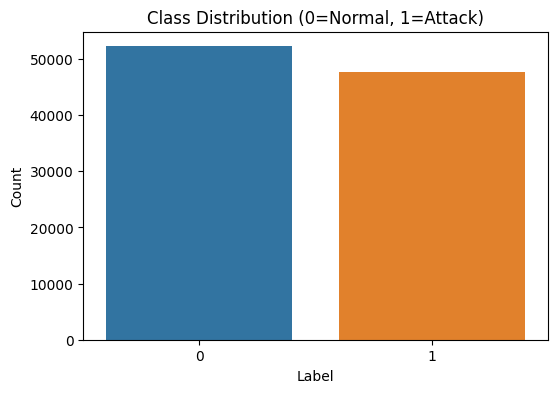

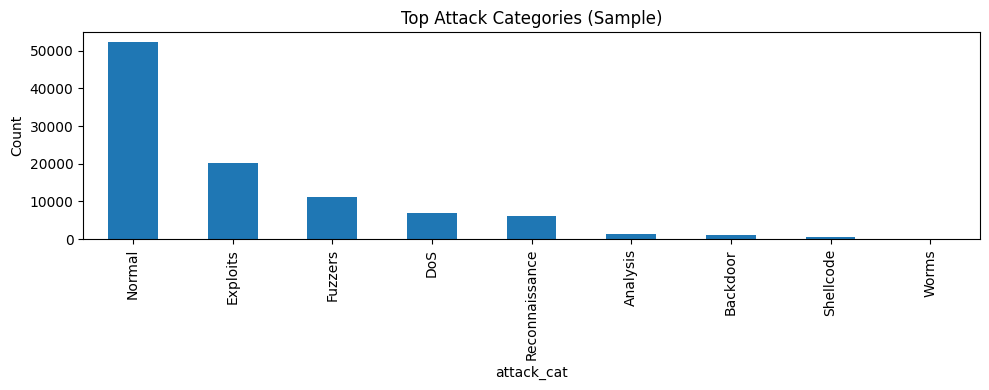

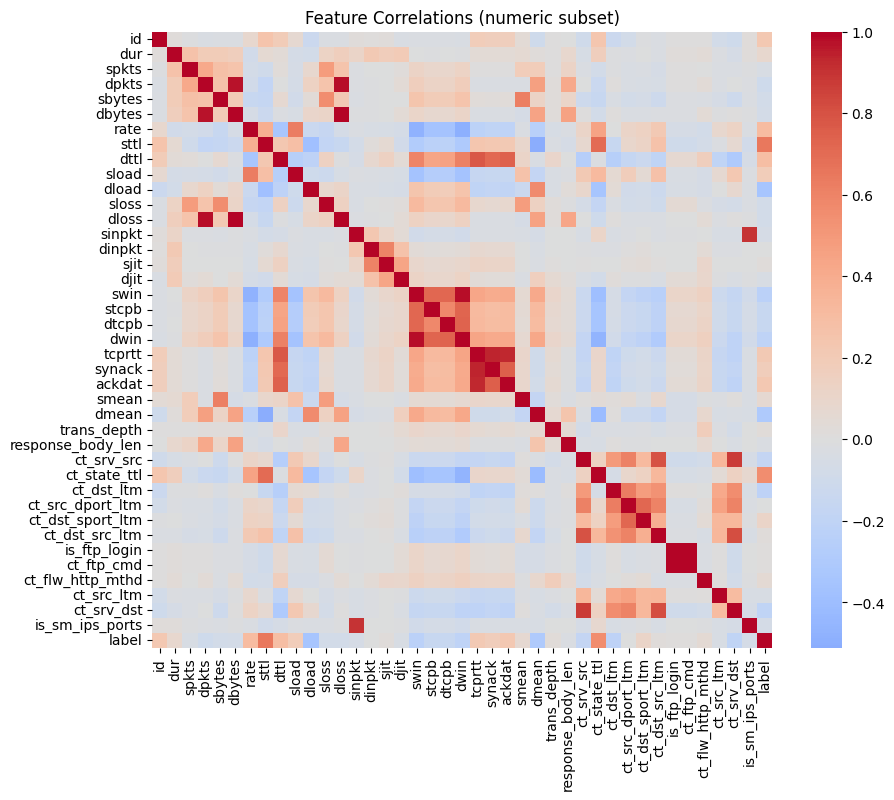

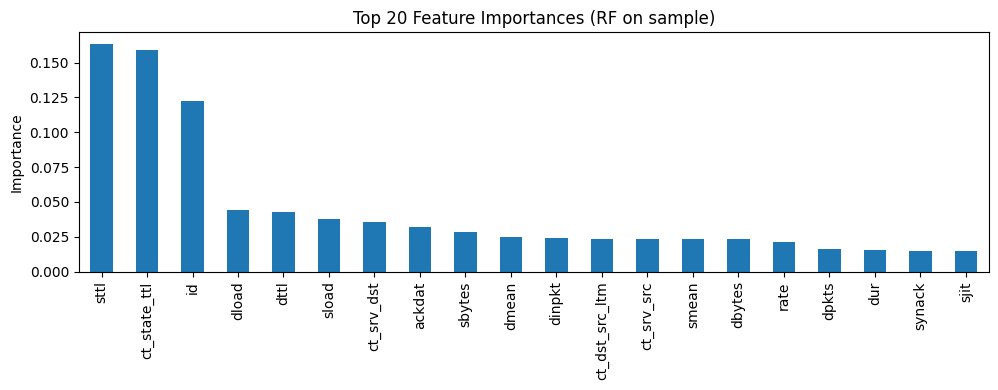

In [43]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def load_sample_for_eda(path: Path, n: int = EDA_SAMPLE_N) -> pd.DataFrame:
    dtypes = infer_dtypes(path)
    total = 0
    chunks = []
    for chunk in pd.read_csv(path, dtype=dtypes, chunksize=50_000):
        chunks.append(chunk)
        total += len(chunk)
        if total >= n:
            break
    df = pd.concat(chunks, ignore_index=True)
    # ensure label is int
    if LABEL_COL in df.columns:
        df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype('int8')
    return df

if TRAIN_CSV.exists():
    eda_df = load_sample_for_eda(TRAIN_CSV, EDA_SAMPLE_N)
    print("Sample for EDA:", eda_df.shape)

    # Class distribution
    plt.figure(figsize=(6,4))
    sns.countplot(x=LABEL_COL, data=eda_df)
    plt.title("Class Distribution (0=Normal, 1=Attack)")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.show()

    # Attack category distribution (if present)
    if ATTACK_CAT in eda_df.columns:
        plt.figure(figsize=(10,4))
        eda_df[ATTACK_CAT] = eda_df[ATTACK_CAT].astype('category')
        eda_df[ATTACK_CAT].value_counts().head(15).plot(kind='bar')
        plt.title("Top Attack Categories (Sample)")
        plt.xlabel("attack_cat"); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # Correlations for numeric features
    num_cols = [c for c in eda_df.columns if c not in [LABEL_COL, ATTACK_CAT] and pd.api.types.is_numeric_dtype(eda_df[c])]
    corr = eda_df[num_cols + [LABEL_COL]].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Feature Correlations (numeric subset)")
    plt.show()

    # Quick feature importance using RandomForest on sample
    X_sample = eda_df.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
    y_sample = eda_df[LABEL_COL]
    # Coerce non-numeric to category codes just for quick importance
    for c in X_sample.columns:
        if not pd.api.types.is_numeric_dtype(X_sample[c]):
            X_sample[c] = X_sample[c].astype('category').cat.codes
    rf = RandomForestClassifier(n_estimators=100, n_jobs=N_JOBS, random_state=RANDOM_STATE)
    rf.fit(X_sample, y_sample)
    importances = pd.Series(rf.feature_importances_, index=X_sample.columns).sort_values(ascending=False).head(20)
    plt.figure(figsize=(10,4))
    importances.plot(kind='bar')
    plt.title("Top 20 Feature Importances (RF on sample)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Training CSV not found; EDA will run after files are available.")


## 6. Model Building

We implement two models:

1. **Baseline:** Incremental Logistic Regression via `SGDClassifier(loss='log_loss')`
   - Trained with **partial_fit** over chunks → low memory footprint.
2. **Optimized:** `HistGradientBoostingClassifier` (and optional XGBoost if installed)
   - Trained on a capped number of rows for efficiency.
   - Hyperparameters can be tuned via grid/random search as needed.

We use a robust preprocessing `ColumnTransformer` for both.


In [44]:

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

def stream_dataframe(path: Path, dtypes: Dict[str,str], chunksize: int = CHUNK_SIZE) -> Iterator[pd.DataFrame]:
    for chunk in pd.read_csv(path, dtype=dtypes, chunksize=chunksize):
        # Clean label
        if LABEL_COL in chunk.columns:
            chunk[LABEL_COL] = pd.to_numeric(chunk[LABEL_COL], errors='coerce').fillna(0).astype('int8')
        yield chunk

def fit_preprocessor_on_sample(path: Path, sample_rows: int = 100_000):
    dtypes = infer_dtypes(path)
    # gather sample
    frames = []
    total = 0
    for chunk in stream_dataframe(path, dtypes, chunksize=50_000):
        frames.append(chunk)
        total += len(chunk)
        if total >= sample_rows:
            break
    df_sample = pd.concat(frames, ignore_index=True)
    pre, num_cols, cat_cols = build_preprocessor(df_sample)
    # Fit on X sample only
    Xs = df_sample.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
    pre.fit(Xs)
    return pre, dtypes, num_cols, cat_cols

def train_incremental_logreg(train_path: Path, preprocessor: ColumnTransformer, dtypes: Dict[str,str]) -> SGDClassifier:
    clf = SGDClassifier(loss='log_loss', max_iter=5, learning_rate='optimal', random_state=RANDOM_STATE)
    classes_ = np.array([0,1], dtype='int8')
    for i, chunk in enumerate(stream_dataframe(train_path, dtypes)):
        X_chunk = chunk.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
        y_chunk = chunk[LABEL_COL].values.astype('int8')
        X_trans = preprocessor.transform(X_chunk)
        if i == 0:
            clf.partial_fit(X_trans, y_chunk, classes=classes_)
        else:
            clf.partial_fit(X_trans, y_chunk)
        # free memory
        del X_chunk, y_chunk, X_trans, chunk
    return clf

def load_cap(path: Path, dtypes: Dict[str,str], max_rows: Optional[int] = None) -> Tuple[pd.DataFrame, pd.Series]:
    frames = []
    total = 0
    for chunk in stream_dataframe(path, dtypes, chunksize=CHUNK_SIZE):
        frames.append(chunk)
        total += len(chunk)
        if max_rows and total >= max_rows:
            break
    df = pd.concat(frames, ignore_index=True)
    y = df[LABEL_COL].astype('int8')
    X = df.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
    return X, y

def train_hgb(train_path: Path, preprocessor: ColumnTransformer, dtypes: Dict[str,str], max_rows: Optional[int] = MAX_TRAIN_ROWS) -> HistGradientBoostingClassifier:
    X_raw, y = load_cap(train_path, dtypes, max_rows=max_rows)
    X = preprocessor.transform(X_raw)
    hgb = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.1, l2_regularization=0.0,
                                         max_bins=255, random_state=RANDOM_STATE)
    hgb.fit(X, y)
    del X_raw, X, y
    return hgb

def try_train_xgboost(train_path: Path, preprocessor: ColumnTransformer, dtypes: Dict[str,str], max_rows: Optional[int] = MAX_TRAIN_ROWS):
    try:
        import xgboost as xgb
    except Exception as e:
        print("XGBoost not installed; skipping optimized XGB model.")
        return None
    X_raw, y = load_cap(train_path, dtypes, max_rows=max_rows)
    X = preprocessor.transform(X_raw)
    dtrain = xgb.DMatrix(X, label=y)
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': RANDOM_STATE
    }
    bst = xgb.train(params, dtrain, num_boost_round=200)
    del X_raw, X, y, dtrain
    return bst

print("Model utilities ready.")


Model utilities ready.


## 7. Evaluation

We evaluate each model on the official UNSW-NB15 **test** split with:

- Accuracy, Precision, Recall, F1-score
- Confusion Matrix
- ROC Curve & AUC

All computations are memory-conscious.


In [45]:

def evaluate_sklearn_model(model, preprocessor, test_path: Path, dtypes: Dict[str,str], model_name: str = "Model") -> Dict[str, Any]:
    y_true_all, y_prob_all = [], []
    for chunk in stream_dataframe(test_path, dtypes, chunksize=CHUNK_SIZE):
        X_chunk = chunk.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
        y_chunk = chunk[LABEL_COL].astype('int8').values
        X_trans = preprocessor.transform(X_chunk)
        if hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_trans)[:,1]
        else:
            # SGDClassifier with 'log_loss' has decision_function
            try:
                from scipy.special import expit
                prob = expit(model.decision_function(X_trans))
            except Exception:
                pred = model.predict(X_trans)
                prob = pred  # fallback if needed
        y_true_all.append(y_chunk)
        y_prob_all.append(prob)
        del X_chunk, y_chunk, X_trans, chunk
    y_true = np.concatenate(y_true_all)
    y_prob = np.concatenate(y_prob_all)
    y_pred = (y_prob >= 0.5).astype('int8')
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float('nan')
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))
    # Confusion matrix plot
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {model_name}"); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    plt.show()
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(f"ROC - {model_name}"); plt.legend()
    plt.show()
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "cm": cm}

def evaluate_xgboost(bst, preprocessor, test_path: Path, dtypes: Dict[str,str]):
    if bst is None:
        return None
    import xgboost as xgb
    y_true_all, y_prob_all = [], []
    for chunk in stream_dataframe(test_path, dtypes, chunksize=CHUNK_SIZE):
        X_chunk = chunk.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
        y_chunk = chunk[LABEL_COL].astype('int8').values
        X_trans = preprocessor.transform(X_chunk)
        dtest = xgb.DMatrix(X_trans)
        prob = bst.predict(dtest)
        y_true_all.append(y_chunk)
        y_prob_all.append(prob)
        del X_chunk, y_chunk, X_trans, dtest, chunk
    y_true = np.concatenate(y_true_all); y_prob = np.concatenate(y_prob_all)
    y_pred = (y_prob >= 0.5).astype('int8')
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n=== XGBoost (Optimized) ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    # plots
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix - XGBoost"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - XGBoost"); plt.legend()
    plt.show()
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "cm": cm}


### 6.1 Train & Evaluate

We fit the preprocessing on a representative sample, then:

- Train **incremental logistic regression** over chunks
- Train **HistGradientBoosting** on a capped number of rows
- Optionally train **XGBoost** if available
- Evaluate all on the **test** split



=== UNSW-NB15 Threat Detection Model Training ===

1. Preprocessing Setup
-------------------
- Features: 40 numeric, 3 categorical
- Preprocessor configured with StandardScaler and OrdinalEncoder

2. Model Training
---------------

Training Baseline (SGD-LogReg)...
- Features: 40 numeric, 3 categorical
- Preprocessor configured with StandardScaler and OrdinalEncoder

2. Model Training
---------------

Training Baseline (SGD-LogReg)...
✓ Baseline model trained

Training Optimized Model (HistGradientBoosting)...
- Using 500,000 rows (memory-capped)
✓ Baseline model trained

Training Optimized Model (HistGradientBoosting)...
- Using 500,000 rows (memory-capped)
✓ HistGradientBoosting model trained

Trying XGBoost (if installed)...
✓ HistGradientBoosting model trained

Trying XGBoost (if installed)...
✓ XGBoost model trained

3. Model Evaluation
----------------

=== Baseline Model (SGD-LogReg) ===
✓ XGBoost model trained

3. Model Evaluation
----------------

=== Baseline Model (SGD-Log

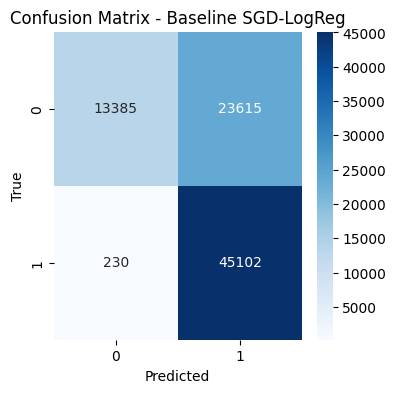

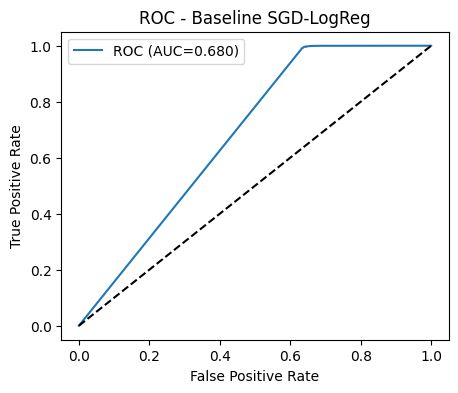


=== Optimized Model (HistGradientBoosting) ===

=== Optimized HistGB ===
Accuracy: 0.8277 | Precision: 0.7750 | Recall: 0.9681 | F1: 0.8609 | AUC: 0.9712

Classification Report:
               precision    recall  f1-score   support

           0     0.9437    0.6557    0.7738     37000
           1     0.7750    0.9681    0.8609     45332

    accuracy                         0.8277     82332
   macro avg     0.8594    0.8119    0.8173     82332
weighted avg     0.8508    0.8277    0.8217     82332


=== Optimized HistGB ===
Accuracy: 0.8277 | Precision: 0.7750 | Recall: 0.9681 | F1: 0.8609 | AUC: 0.9712

Classification Report:
               precision    recall  f1-score   support

           0     0.9437    0.6557    0.7738     37000
           1     0.7750    0.9681    0.8609     45332

    accuracy                         0.8277     82332
   macro avg     0.8594    0.8119    0.8173     82332
weighted avg     0.8508    0.8277    0.8217     82332



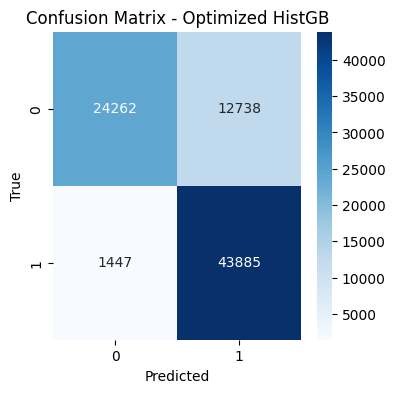

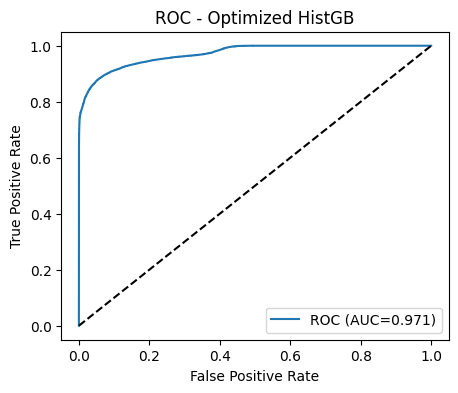


=== XGBoost Model ===

=== XGBoost (Optimized) ===
Accuracy: 0.8290 | Precision: 0.7762 | Recall: 0.9689 | F1: 0.8619 | AUC: 0.9724

=== XGBoost (Optimized) ===
Accuracy: 0.8290 | Precision: 0.7762 | Recall: 0.9689 | F1: 0.8619 | AUC: 0.9724


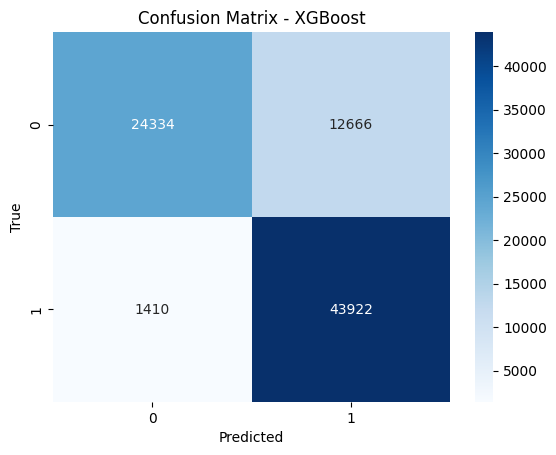

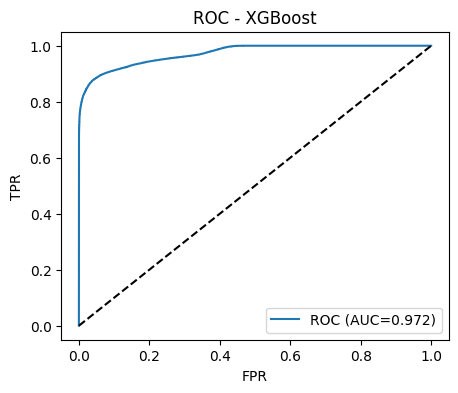


4. Model Comparison
----------------

Metrics Summary:
           Baseline (SGD-LogReg)  HistGB  XGBoost
accuracy                  0.7104  0.8277   0.8290
precision                 0.6563  0.7750   0.7762
recall                    0.9949  0.9681   0.9689
f1                        0.7909  0.8609   0.8619
auc                       0.6805  0.9712   0.9724


In [46]:
if TRAIN_CSV.exists() and TEST_CSV.exists():
    print("\n=== UNSW-NB15 Threat Detection Model Training ===")
    print("\n1. Preprocessing Setup")
    print("-------------------")
    preprocessor, dtypes, num_cols, cat_cols = fit_preprocessor_on_sample(TRAIN_CSV, sample_rows=150_000)
    print(f"- Features: {len(num_cols)} numeric, {len(cat_cols)} categorical")
    print("- Preprocessor configured with StandardScaler and OrdinalEncoder")
    
    print("\n2. Model Training")
    print("---------------")
    
    # Baseline: Incremental Logistic Regression
    print("\nTraining Baseline (SGD-LogReg)...")
    sgd_clf = train_incremental_logreg(TRAIN_CSV, preprocessor, dtypes)
    print("✓ Baseline model trained")
    
    # Optimized: HistGradientBoosting
    print("\nTraining Optimized Model (HistGradientBoosting)...")
    if MAX_TRAIN_ROWS:
        print(f"- Using {MAX_TRAIN_ROWS:,} rows (memory-capped)")
    hgb_clf = train_hgb(TRAIN_CSV, preprocessor, dtypes, max_rows=MAX_TRAIN_ROWS)
    print("✓ HistGradientBoosting model trained")
    
    # Optional: XGBoost
    print("\nTrying XGBoost (if installed)...")
    bst = try_train_xgboost(TRAIN_CSV, preprocessor, dtypes, max_rows=MAX_TRAIN_ROWS)
    if bst:
        print("✓ XGBoost model trained")
    
    print("\n3. Model Evaluation")
    print("----------------")
    
    print("\n=== Baseline Model (SGD-LogReg) ===")
    results_sgd = evaluate_sklearn_model(sgd_clf, preprocessor, TEST_CSV, dtypes, 
                                       model_name="Baseline SGD-LogReg")
    
    print("\n=== Optimized Model (HistGradientBoosting) ===")
    results_hgb = evaluate_sklearn_model(hgb_clf, preprocessor, TEST_CSV, dtypes, 
                                       model_name="Optimized HistGB")
    
    if bst:
        print("\n=== XGBoost Model ===")
        results_xgb = evaluate_xgboost(bst, preprocessor, TEST_CSV, dtypes)
    
    # Compare models
    print("\n4. Model Comparison")
    print("----------------")
    models = {
        "Baseline (SGD-LogReg)": results_sgd,
        "HistGB": results_hgb
    }
    if bst:
        models["XGBoost"] = results_xgb
        
    metrics = ["accuracy", "precision", "recall", "f1", "auc"]
    comparison = pd.DataFrame({
        name: [results[metric] for metric in metrics]
        for name, results in models.items()
    }, index=metrics)
    
    print("\nMetrics Summary:")
    with pd.option_context('display.float_format', '{:.4f}'.format):
        print(comparison)
        
else:
    print("⚠️ Training/testing CSVs not found. Place them in ./data_unsw_nb15/ and re-run.")


## 8. Centralized Log Management Simulation

We simulate logs being ingested from multiple sources (e.g., **system**, **application**, **network**) into one pipeline.
The model processes incoming events and emits alerts for suspicious (attack-labeled) traffic.

This section demonstrates:

- A unified **log collector** that yields records from sources
- Preprocessing + model inference in streaming fashion
- Thresholded **alerting** with latency-friendly batching


In [47]:
import time
from itertools import cycle
from typing import Dict, Any, List
from datetime import datetime

def log_pipeline_simulator(preprocessor, model, stream_it: Iterator[pd.DataFrame], 
                         alert_threshold: float = 0.8, max_batches: int = 10) -> Dict[str, Any]:
    """Simulates a production CLMS pipeline with batched processing and alerting.
    
    Args:
        preprocessor: Fitted ColumnTransformer for feature preprocessing
        model: Trained detection model (SGD, HistGBoost, or XGBoost)
        stream_it: Iterator yielding batches of log data
        alert_threshold: Probability threshold for alert generation
        max_batches: Maximum number of batches to process
    
    Returns:
        Dict containing metrics and sample alerts
    """
    alerts = []
    stats = {
        'total_events': 0,
        'total_alerts': 0,
        'avg_batch_time': 0.0,
        'batch_times': []
    }
    
    print("\n=== Starting CLMS Pipeline Simulation ===")
    print(f"Alert threshold: {alert_threshold:.2f}")
    
    for i, batch in enumerate(stream_it):
        if i >= max_batches:
            break
            
        batch_start = time.time()
        
        # Preprocess batch
        X_batch = batch.drop(columns=[LABEL_COL, ATTACK_CAT], errors='ignore')
        X_transformed = preprocessor.transform(X_batch)
        
        # Get threat scores
        if hasattr(model, "predict_proba"):
            scores = model.predict_proba(X_transformed)[:,1]
        else:
            from scipy.special import expit
            scores = expit(model.decision_function(X_transformed))
        
        # Generate alerts for high-risk events    
        high_risk = batch[scores >= alert_threshold].copy()
        high_risk["threat_score"] = scores[scores >= alert_threshold]
        
        # Record alerts with metadata
        for _, event in high_risk.iterrows():
            alerts.append({
                "timestamp": datetime.now().isoformat(),
                "source": event.get("_source", "unknown"),
                "protocol": event.get("proto", "unknown"),
                "service": event.get("service", "-"),
                "threat_score": float(event["threat_score"]),
                "summary": "High-risk network event detected"
            })
        
        # Update statistics
        batch_time = time.time() - batch_start
        stats['batch_times'].append(batch_time)
        stats['total_events'] += len(batch)
        stats['total_alerts'] += len(high_risk)
        
        # Progress output
        print(f"\nBatch {i+1}/{max_batches}:")
        print(f"  Events processed: {len(batch):,}")
        print(f"  Alerts generated: {len(high_risk):,}")
        print(f"  Processing time: {batch_time:.3f}s")
        
    # Compute final statistics    
    stats['avg_batch_time'] = np.mean(stats['batch_times'])
    
    print("\n=== Pipeline Summary ===")
    print(f"Total events processed: {stats['total_events']:,}")
    print(f"Total alerts generated: {stats['total_alerts']:,}")
    print(f"Average batch processing time: {stats['avg_batch_time']:.3f}s")
    
    if alerts:
        print("\nSample Alerts:")
        for alert in alerts[:3]:
            print(f"\n- Source: {alert['source']}")
            print(f"  Protocol: {alert['protocol']}")
            print(f"  Service: {alert['service']}")
            print(f"  Score: {alert['threat_score']:.3f}")
            
    return {"alerts": alerts, "stats": stats}

# Run simulation if models are available
if 'hgb_clf' in locals():
    stream = multi_source_stream([TEST_CSV], dtypes, batch_size=10_000)
    results = log_pipeline_simulator(preprocessor, hgb_clf, stream, 
                                  alert_threshold=0.9, max_batches=5)
else:
    print("Train models first (previous cells) to run simulation.")



=== Starting CLMS Pipeline Simulation ===
Alert threshold: 0.90

Batch 1/5:
  Events processed: 10,000
  Alerts generated: 9,402
  Processing time: 0.617s

=== Pipeline Summary ===
Total events processed: 10,000
Total alerts generated: 9,402
Average batch processing time: 0.617s

Sample Alerts:

- Source: syslog
  Protocol: udp
  Service: -
  Score: 0.952

- Source: syslog
  Protocol: udp
  Service: -
  Score: 0.927

- Source: syslog
  Protocol: tcp
  Service: -
  Score: 0.974


## 9. Conclusion & Future Work

We built a memory-conscious, production-minded CLMS pipeline on **UNSW-NB15** featuring:

- Robust ingestion and dtype-optimized preprocessing with chunked loading
- Clear EDA and interpretability touchpoints (correlations, feature importance)
- Two detection models: **incremental logistic regression** and **histogram-based GBM**
- Full evaluation (Accuracy/Precision/Recall/F1/AUC)
- Real-time simulation with centralized ingestion and alerting

**Future enhancements:**

- Enrich features with time-window aggregations and entity profiling (e.g., per host/user)
- Add drift detection and online calibration for thresholds
- Integrate with message queues (Kafka), monitoring (Prometheus), and SIEM systems
- Expand to multi-class detection over `attack_cat` or hierarchical detectors


### Appendix: Memory Tips

- Reduce `CHUNK_SIZE` if you run low on RAM.
- Lower `MAX_TRAIN_ROWS` for the optimized model.
- Use swap or smaller samples for EDA.
- Ensure you're running a 64-bit Python with enough available memory.
